In [ ]:
!pip install torchvision
!pip install --upgrade transformers
!pip install mmocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 114.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvji

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
^C


In [ ]:
import os

# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expendable_segments:True"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

zipPath = '/content/drive/MyDrive/train_val_images.zip'
zipPathTest = '/content/drive/MyDrive/test_images.zip'
annsPathTrain = '/content/drive/MyDrive/TextOCR_0.1_train.json'
annsPathVal = '/content/drive/MyDrive/TextOCR_0.1_val.json'
annsPathTest = '/content/drive/MyDrive/TextOCR_0.1_test.json'
stepDir = "/content/drive/MyDrive/checkpoint/donut/"

In [ ]:
import zipfile
from PIL import Image
from IPython.display import display
import io

data = zipfile.ZipFile(zipPath, 'r')
images = [f for f in data.namelist() if f.startswith("train_images/") and f.endswith('.jpg')]
file = data.open(images[1000])
img = Image.open(io.BytesIO(file.read())).convert("RGB")
display(img)

In [ ]:
if os.path.exists(stepDir):
  print("yes")
else:
  print("no")

In [ ]:
from transformers import VisionEncoderDecoderModel, DonutProcessor

if os.path.exists("/content/drive/MyDrive/models/model"):
  model = VisionEncoderDecoderModel.from_pretrained("/content/drive/MyDrive/models/model")
elif os.path.exists(stepDir):
  model = VisionEncoderDecoderModel.from_pretrained(stepDir)
else:
  model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base")
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")
processor.feature_extractor.size = {"height": 512, "width": 512}
print(processor.image_processor.size)

NameError: name 'os' is not defined

In [ ]:
from PIL import ImageOps

def resizeMaintainRatio(image, size=(1920, 2560)):
  w, h = image.size
  scale = min(size[0] / w, size[1] / h)
  newW, newH = int(w * scale), int(h * scale)
  newImg = image.resize((newW, newH))

  deltaW = size[0] - newW
  deltaH = size[1] - newH
  padding = (deltaW // 2, deltaH // 2, deltaW - (deltaW // 2), deltaH - (deltaH // 2))
  newImg = ImageOps.expand(newImg, padding, fill = (255, 255, 255))
  return newImg

In [ ]:
import json
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
import numpy as np
import random

class ZippedDataset(Dataset):
  def __init__(self, zipPath, annsPath, processor, isTest, maxLength = 50, maxSamples = None):
    self.zipPath = zipPath
    self.annsPath = annsPath
    self.processor = processor
    self.maxLength = maxLength
    self.archive = zipfile.ZipFile(self.zipPath, 'r')

    with open(self.annsPath, 'r') as f:
      annotations = json.load(f)
    self.imgs = annotations["imgs"]
    self.anns = annotations["anns"]

    self.samples = []
    minBox = (20, 20)
    img = None
    curImgID = ""
    for ann in self.anns.values():
      imgID = ann["image_id"]
      text = ann["utf8_string"].strip()
      bbox = ann["bbox"]
      zipImgPath = self.imgs[imgID]["file_name"]
      zipImgPath = zipImgPath.replace("test/", "test_images/") if isTest else zipImgPath.replace("train/", "train_images/")
      if img is None or imgID != curImgID:
        with self.archive.open(zipImgPath) as f:
          img = Image.open(io.BytesIO(f.read())).convert("RGB")
        curImgID = imgID
      x, y, w, h = bbox
      if w < minBox[0] or h < minBox[1]:
        continue
      cropped = img.crop((x, y, x + w, y + h))
      if self.tooBlurry(cropped) or text == "" or text == ".":
        continue
      self.samples.append((zipImgPath, bbox, text))
      if len(self.samples) == maxSamples:
        break

  def __len__(self):
    return len(self.samples)

  def __getitem__(self, idx):
    zipImgPath, bbox, label = self.samples[idx]
    with self.archive.open(zipImgPath) as f:
      img = Image.open(io.BytesIO(f.read())).convert("RGB")
    x, y, w, h = bbox
    cropped = img.crop((x, y, x + w, y + h))
    cropped = resizeMaintainRatio(cropped, (512, 512))
    pixelValues = self.processor(cropped, return_tensors = "pt").pixel_values[0]
    labels = self.processor.tokenizer(label, max_length = self.maxLength, padding = "max_length", truncation = True, return_tensors = "pt").input_ids.squeeze(0)
    labels[labels == self.processor.tokenizer.pad_token_id] = -100
    return {"pixel_values": pixelValues, "labels": labels}

  def sendItem(self, idx):
    zipImgPath, bbox, label = self.samples[idx]
    with self.archive.open(zipImgPath) as f:
      img = Image.open(io.BytesIO(f.read())).convert("RGB")
    x, y, w, h = bbox
    cropped = img.crop((x, y, x + w, y + h))
    cropped = resizeMaintainRatio(cropped, (512, 512))
    return cropped, label

  def tooBlurry(self, img, threshold = 100):
    img = np.array(img)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F).var()
    return laplacian < threshold

  def printLabel(self, idx):
    _ , label = self.samples[idx]
    print(label)

In [ ]:
from torch.utils.data import random_split
import torch

datasetTrain = ZippedDataset(zipPath, annsPathTrain, processor, False, maxSamples = 40000)
generator = torch.Generator().manual_seed(44)
datasubTrain, datasubVal = random_split(datasetTrain, [int(len(datasetTrain) * 0.9), len(datasetTrain) - int(len(datasetTrain) * 0.9)], generator = generator)
dataloaderTrain = DataLoader(datasubTrain, batch_size = 24, shuffle = True)
dataloaderVal = DataLoader(datasubVal, batch_size = 1)
print(len(datasubTrain))
print(len(datasubVal))

36000
4000


In [ ]:
# cell used for debugging

import numpy as np

# "train_images/a4ea732cd3d5948a.jpg"
# "train_images/0000e8b36676338b.jpg"

archive = zipfile.ZipFile(zipPath, 'r')
img = ""
with archive.open("train_images/a4ea732cd3d5948a.jpg") as f:
    img = Image.open(io.BytesIO(f.read())).convert("RGB")
img = resizeMaintainRatio(img)
print(np.array(img).shape)
print(np.array(img).min(), np.array(img).max())
display(img)
pixelValues = processor(img, return_tensors = "pt", do_normalize = False).pixel_values[0]
print(pixelValues)

In [ ]:
# also a debugging cell

for i in range(pixelValues.shape[0]):
  for j in range(pixelValues.shape[1]):
    for k in range(pixelValues.shape[2]):
      if pixelValues[i, j, k] != 1:
        print(pixelValues[i, j, k])

Streaming output truncated to the last 5000 lines.
tensor(0.2588)
tensor(0.2627)
tensor(0.2706)
tensor(0.2706)
tensor(0.2706)
tensor(0.2706)
tensor(0.2706)
tensor(0.2706)
tensor(0.2667)
tensor(0.2627)
tensor(0.2588)
tensor(0.2627)
tensor(0.2588)
tensor(0.2549)
tensor(0.2549)
tensor(0.2627)
tensor(0.2706)
tensor(0.2706)
tensor(0.2706)
tensor(0.2706)
tensor(0.2667)
tensor(0.2627)
tensor(0.2627)
tensor(0.2667)
tensor(0.2667)
tensor(0.2706)
tensor(0.2706)
tensor(0.2667)
tensor(0.2745)
tensor(0.2824)
tensor(0.2863)
tensor(0.2863)
tensor(0.2824)
tensor(0.2824)
tensor(0.2824)
tensor(0.2902)
tensor(0.2980)
tensor(0.3098)
tensor(0.3373)
tensor(0.3725)
tensor(0.4118)
tensor(0.4549)
tensor(0.4902)
tensor(0.5294)
tensor(0.5608)
tensor(0.5882)
tensor(0.6078)
tensor(0.6314)
tensor(0.6471)
tensor(0.6588)
tensor(0.6627)
tensor(0.6706)
tensor(0.6706)
tensor(0.6745)
tensor(0.6784)
tensor(0.6784)
tensor(0.6824)
tensor(0.6863)
tensor(0.6824)
tensor(0.6863)
tensor(0.6902)
tensor(0.6941)
tensor(0.6980)
tens

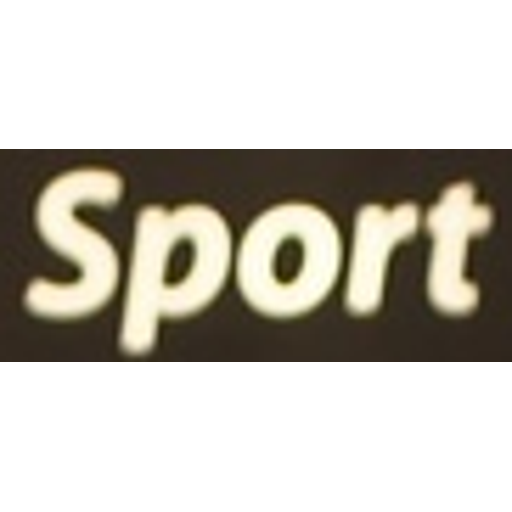

Sport


In [ ]:
# another debugging cell

img, label = datasetTrain.sendItem(1)
display(img)
print(label)

In [ ]:
model.config.decoder_start_token_id = processor.tokenizer.bos_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.eos_token_id = processor.tokenizer.eos_token_id

print("Decoder start token:", processor.tokenizer.convert_ids_to_tokens(model.config.decoder_start_token_id))
print("Pad token:", processor.tokenizer.pad_token, "ID:", model.config.pad_token_id)
print("EOS token:", processor.tokenizer.eos_token, "ID:", model.config.eos_token_id)

Decoder start token: <s>
Pad token: <pad> ID: 1
EOS token: </s> ID: 2


In [ ]:
import torch
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

numEpochs = 3
accumulationSteps = 4
numTrainingSteps = numEpochs * len(dataloaderTrain)
optimizer = AdamW(model.parameters(), lr = 2e-5, weight_decay=0.01)
lrScheduler = get_linear_schedule_with_warmup(optimizer = optimizer, num_warmup_steps = 1000, num_training_steps = numTrainingSteps)
if os.path.exists(stepDir):
  optimizer.load_state_dict(torch.load(os.path.join(stepDir, "optimizer.pt")))
  lrScheduler.load_state_dict(torch.load(os.path.join(stepDir, "lrScheduler.pt")))

In [ ]:
import gc
import torch

torch.cuda.empty_cache()
gc.collect()
torch.cuda.ipc_collect()

In [ ]:
class EarlyStopping:
  def __init__(self, patience = 1, delta = 0):
    self.patience = patience
    self.delta = delta
    self.counter = 0
    self.bestLoss = float("inf")
    self.earlyStop = False

  def __call__(self, valLoss):
    if valLoss < self.bestLoss - self.delta:
      self.bestLoss = valLoss
      self.counter = 0
    else:
      self.counter += 1
      if self.counter >= self.patience:
        self.earlyStop = True

In [ ]:
import torch.nn.functional as F

def labelSmoothedNLLLoss(logits, target, epsilon = 0.1, ignoreIdx = -100):
  target = torch.clamp(target, 0, logits.size(-1) - 1)
  mask = target != ignoreIdx
  logProbs = F.log_softmax(logits, dim = -1)
  nClasses = logits.size(-1)
  trueDist = torch.zeros_like(logProbs)
  trueDist.fill_(epsilon / (nClasses - 1))
  trueDist.scatter_(2, target.unsqueeze(-1), 1 - epsilon)
  loss = -(trueDist * logProbs).sum(dim = -1)
  loss = loss[mask]
  return loss.mean()

def tokenConfidencePenalty(logits):
  logProbs = F.log_softmax(logits, dim = -1)
  entropy = -torch.sum(torch.exp(logProbs) * logProbs, dim = -1)
  return entropy.mean()

In [ ]:
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()
earlyStopper = EarlyStopping(patience = 0)
model.gradient_checkpointing_enable()
if os.path.exists(stepDir):
  with open(os.path.join(stepDir, "meta.json"), "r") as f:
    meta = json.load(f)
  globalStep = meta.get("global_step", 0)
  startEpoch = meta.get("epoch", 0)
else:
  globalStep = 0
  startEpoch = 0
lenPenalty = 0.05

for epoch in range(startEpoch, numEpochs):
  print(f"Epoch {epoch + 1}/{numEpochs}")
  runningLoss = 0.0
  model.train()
  optimizer.zero_grad()
  trainLoss = 0.0
  pbar = tqdm(dataloaderTrain, desc = "Training")
  for step, batch in enumerate(pbar):
    batch = {k: v.to(device) for k, v in batch.items()}
    with autocast(enabled = True):
      outputs = model(**batch)
      logits = outputs.logits
      labels = batch["labels"]
      loss = labelSmoothedNLLLoss(logits, labels, epsilon = 0.1)
      predictedIDs = logits.detach().argmax(dim = -1)
      predictedLengths = (predictedIDs != processor.tokenizer.pad_token_id).sum(dim = 1).float()
      avgLength = predictedLengths.mean()
      loss = loss + lenPenalty * avgLength
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    lrScheduler.step()
    optimizer.zero_grad()

    runningLoss += loss.item()
    pbar.set_postfix(loss = runningLoss / (step + 1))

  del loss, outputs, batch
  gc.collect()
  avgTrainLoss = runningLoss / len(dataloaderTrain)
  print(f"Training loss: {avgTrainLoss:.4f}")

  model.eval()
  valLoss = 0.0
  with torch.no_grad():
    for batch in dataloaderVal:
      batch = {k: v.to(device) for k, v in batch.items()}
      with autocast(enabled = True):
        outputs = model(**batch)
        loss = outputs.loss
      valLoss += loss.item()
  avgValLoss = valLoss / len(dataloaderVal)
  print(f"Validation loss: {avgValLoss:.4f}")
  earlyStopper(avgValLoss)
  if earlyStopper.earlyStop:
    print("Early stopping!")
    break

  os.makedirs(stepDir, exist_ok = True)
  model.save_pretrained(stepDir)
  processor.save_pretrained(stepDir)
  torch.save(optimizer.state_dict(), os.path.join(stepDir, "optimizer.pt"))
  torch.save(lrScheduler.state_dict(), os.path.join(stepDir, "lrScheduler.pt"))
  with open(os.path.join(stepDir, "meta.json"), "w") as f:
    json.dump({"global_step": globalStep, "epoch": epoch}, f)

  torch.cuda.empty_cache()
  del loss, outputs, batch
  gc.collect()
  torch.cuda.ipc_collect()

<ipython-input-15-e7837f5021af>:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/10


Training:   0%|          | 0/450 [00:00<?, ?it/s]<ipython-input-15-e7837f5021af>:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled = True):
`use_cache=True` is incompatible with gradient checkpointing`. Setting `use_cache=False`...
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.
Training: 100%|██████████| 450/450 [19:44<00:00,  2.63s/it, loss=5.88]


Training loss: 5.8783


<ipython-input-15-e7837f5021af>:69: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled = True):


Validation loss: 6.8996
Epoch 2/10


Training: 100%|██████████| 900/900 [39:31<00:00,  2.64s/it, loss=4.14]


Training loss: 4.1415
Validation loss: 9.8724
Epoch 3/10


Training: 100%|██████████| 1500/1500 [1:05:49<00:00,  2.63s/it, loss=4.03]


Training loss: 4.0297
Validation loss: 10.3405
Epoch 4/10


Training:  77%|███████▋  | 1150/1500 [50:36<28:37,  4.91s/it, loss=4]<ipython-input-15-e7837f5021af>:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled = True):
Training: 100%|██████████| 1500/1500 [1:06:01<00:00,  2.64s/it, loss=4]


Training loss: 3.9995


<ipython-input-15-e7837f5021af>:69: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled = True):


Validation loss: 10.7129
Early stopping!


In [ ]:
model.save_pretrained("/content/drive/MyDrive/models/model")

In [ ]:
datasetTest = ZippedDataset(zipPath, annsPathVal, processor, False, maxSamples = 4000)
dataloaderTest = DataLoader(datasetTest, batch_size = 1)
print(len(datasetTest))

4000


In [ ]:
!pip install jiwer

In [ ]:
from jiwer import cer
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler

model.eval()
totalCER = 0.0
results = []
idx = 0

for batch in tqdm(dataloaderTest, desc = "Testing"):
  with torch.no_grad():
    pixelValues = batch["pixel_values"].to(device)
    labels = batch["labels"].clone()
    labels[labels == -100] = processor.tokenizer.pad_token_id
    outputs = model.generate(pixelValues, max_length = 50, num_beams = 1, do_sample = False, early_stopping = True)
    decode = processor.batch_decode(outputs, skip_special_tokens = True)
    labelStr = processor.batch_decode(labels, skip_special_tokens = True)
    for pred, ref in zip(decode, labelStr):
      if not ref == "":
        result = {"idx": idx, "prediction": pred, "label": ref}
        results.append(result)
        idx += 1

avgCer = sum(cer(r["label"], r["prediction"]) for r in results) / len(results)
print(f"CER: {avgCer:.4f}")
print("Sample prediction")
print("Pred:", results[0]["prediction"])
print("Label:", results[0]["label"])

Testing:   0%|          | 0/4000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:679: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
Testing: 100%|██████████| 4000/4000 [05:00<00:00, 13.30it/s]

CER: 0.3459
Sample prediction
Pred: VIGNE
Label: VIGNE


In [ ]:
print(results[9])

{'idx': 9, 'prediction': 'Whansanna', 'label': 'luthansa.com'}


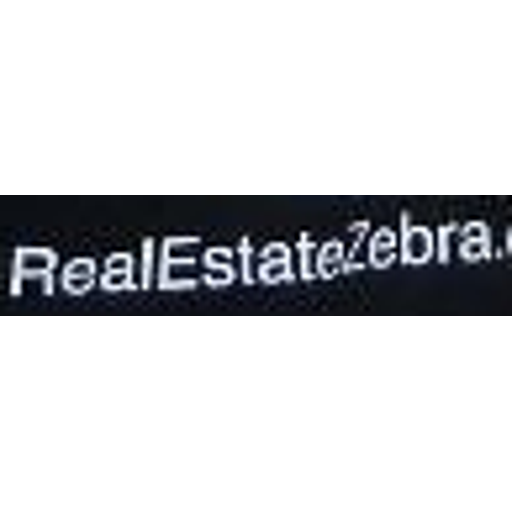

RealEstateZebra.


In [ ]:
img, label = datasetTest.sendItem(0)
display(img)
print(label)

In [ ]:
os.makedirs("/content/drive/MyDrive/DonutResults", exist_ok = True)

In [ ]:
with open("/content/drive/MyDrive/DonutResults/results_baseline.json", "w") as f:
  json.dump({
    "average_CER": avgCer,
    "results": results
  }, f, indent=2)

In [ ]:
data.close()